For MS training we have 3 datasets: train, validation and holdout

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib

from scipy import interp
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import os
import time
import h5py

# keras
from keras.models import Sequential
from keras.layers import Input, Conv3D, Flatten, Dense, MaxPooling3D, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence
import keras.backend as K

from config import *
from utils import specificity, sensitivity, balanced_accuracy, IntensityRescale, sagittal_flip, translate

Using TensorFlow backend.


In [2]:
# Start timing
start_time = time.time()

In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "6"
set_session(tf.Session(config=config))

In [4]:
zero_one_normalize = True
dtype = np.float32
result_dir = "/analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/MS_from_scratch"

In [5]:
!mkdir -p $result_dir

In [6]:
# load hdf5 files and extract columns
train_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/train_dataset.h5', 'r')
holdout_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/holdout_dataset.h5', 'r')

X_train, y_train = train_h5['X'], train_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [7]:
# convert data to numpy arrays
X_train = np.array(X_train, dtype=dtype)
y_train = np.array(y_train)

X_holdout = np.array(X_holdout, dtype=dtype)
y_holdout = np.array(y_holdout)

In [8]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
print("Number of MS patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))

Total datset length: 124
Number of healthy controls: 61
Number of MS patients: 63


In [9]:
class CISDataset(Sequence):
    def __init__(self, X, y, transform=None, batch_size=4, z_factor=None, shuffle=True, mask=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.batch_size = batch_size
        self.z_factor = z_factor
        self.shuffle = shuffle
        self.mask = mask
        
    def __len__(self):
        return int(np.ceil(len(self.y)/self.batch_size))
    
    def __getitem__(self, idx):
        # add BET
        image = np.expand_dims(self.X[idx * self.batch_size:(idx + 1) * self.batch_size],5)
        #label = np.array((batch_idx['label'] == "MS")* 1, dtype=np.int8) 
        label = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype=np.int8)
        
        if self.mask is not None:
            for i in range(image.shape[0]):
                image[i] *= self.mask
        
        for transformation in self.transform:
            image = transformation(image)
        
        return image, label
    
    def on_epoch_end(self):
        if self.shuffle:
            self.X, self.y = shuffle(self.X, self.y)

In [10]:
mask = None

In [11]:
intensity = IntensityRescale(masked=False)

In [12]:
if zero_one_normalize:
    cis_data = CISDataset(X_train, y_train, transform=[intensity], batch_size=4)
else:
    cis_data = CISDataset(X_train, y_train, batch_size=4)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


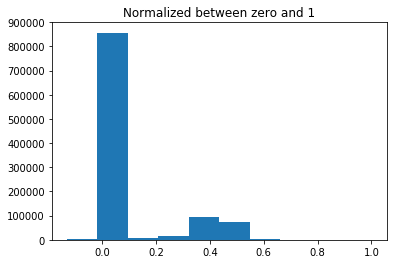

In [13]:
plt.figure()
plt.title("Normalized between zero and 1")
plt.hist(cis_data[4][0][0].flatten())
plt.show()

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


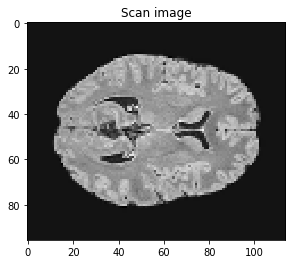

In [14]:
plt.figure()
plt.title("Scan image")
plt.imshow(np.squeeze(cis_data[4][0][0])[:,:,42], cmap='gray')
plt.show()

# Model

In [15]:
def SixtyFourNet(input_shape, drop_rate=0., weight_dcay=0.):
    model = Sequential()
    model.add(Conv3D(64, kernel_size=3, 
                     input_shape=(input_shape[1], input_shape[2], input_shape[3], 1), 
                     activation='elu', padding='valid', name='Conv_1'))
    model.add(MaxPooling3D(pool_size=3, name='Pool_1'))
    model.add(Dropout(drop_rate))
    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_2'))

    model.add(MaxPooling3D(pool_size=3, name='Pool_2'))
    model.add(Dropout(drop_rate))

    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_3',
                     kernel_regularizer=l2(weight_dcay)))
    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_4',
                     kernel_regularizer=l2(weight_dcay)))
    model.add(MaxPooling3D(pool_size=3, name='Pool_4'))
    model.add(Dropout(drop_rate))

    model.add(Flatten())
    model.add(Dense(units=1, activation='sigmoid'))
    return model

## Training

In [16]:
X_train.shape

(124, 96, 114, 96)

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# split training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=77)

Trial 0
Epoch 1/200


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


27/27 [==============================] - 8s 300ms/step - loss: 1.9472 - acc: 0.4634 - val_loss: 1.8260 - val_acc: 0.6842

Epoch 00001: val_acc improved from -inf to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/MS_from_scratch/weights-augm-trial0-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 150ms/step - loss: 1.7913 - acc: 0.5273 - val_loss: 1.7032 - val_acc: 0.5789

Epoch 00002: val_acc did not improve from 0.68421
Epoch 3/200
27/27 [==============================] - 4s 164ms/step - loss: 1.6336 - acc: 0.5366 - val_loss: 1.6979 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 159ms/step - loss: 1.5152 - acc: 0.5932 - val_loss: 1.4125 - val_acc: 0.6842

Epoch 00004: val_acc did not improve from 0.68421
Epoch 5/200
27/27 [==============================] - 4s 160ms/step - loss: 1.4574 - acc: 0.5469 - val_loss: 1.3472 - val_acc: 0.6842

Ep

27/27 [==============================] - 5s 168ms/step - loss: 0.5500 - acc: 0.7405 - val_loss: 0.5323 - val_acc: 0.6842

Epoch 00043: val_acc did not improve from 0.84211
Epoch 44/200
27/27 [==============================] - 4s 156ms/step - loss: 0.5761 - acc: 0.7127 - val_loss: 0.6518 - val_acc: 0.6842

Epoch 00044: val_acc did not improve from 0.84211
Epoch 45/200
27/27 [==============================] - 4s 165ms/step - loss: 0.5710 - acc: 0.7683 - val_loss: 0.5300 - val_acc: 0.8421

Epoch 00045: val_acc did not improve from 0.84211
Epoch 46/200
27/27 [==============================] - 5s 172ms/step - loss: 0.6191 - acc: 0.6488 - val_loss: 0.5889 - val_acc: 0.6842

Epoch 00046: val_acc did not improve from 0.84211
Epoch 47/200
27/27 [==============================] - 5s 170ms/step - loss: 0.5572 - acc: 0.7868 - val_loss: 0.5149 - val_acc: 0.8421

Epoch 00047: val_acc did not improve from 0.84211
Epoch 48/200
27/27 [==============================] - 4s 162ms/step - loss: 0.5627 - acc


Epoch 00086: val_acc did not improve from 0.84211
Epoch 87/200
27/27 [==============================] - 4s 151ms/step - loss: 0.3872 - acc: 0.8888 - val_loss: 0.5062 - val_acc: 0.8421

Epoch 00087: val_acc did not improve from 0.84211
Epoch 88/200
27/27 [==============================] - 4s 159ms/step - loss: 0.4186 - acc: 0.8332 - val_loss: 0.5015 - val_acc: 0.8421

Epoch 00088: val_acc did not improve from 0.84211
Epoch 89/200
27/27 [==============================] - 4s 166ms/step - loss: 0.3827 - acc: 0.8795 - val_loss: 0.4961 - val_acc: 0.8421

Epoch 00089: val_acc did not improve from 0.84211
Epoch 90/200
27/27 [==============================] - 5s 167ms/step - loss: 0.3791 - acc: 0.8610 - val_loss: 0.5047 - val_acc: 0.8421

Epoch 00090: val_acc did not improve from 0.84211
Epoch 91/200
27/27 [==============================] - 5s 170ms/step - loss: 0.3958 - acc: 0.8795 - val_loss: 0.4915 - val_acc: 0.8421

Epoch 00091: val_acc did not improve from 0.84211
Epoch 92/200
27/27 [====

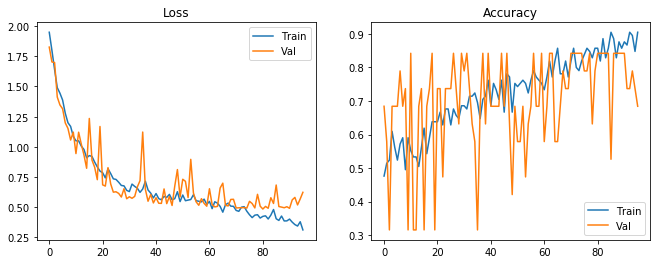

Trial 1
Epoch 1/200
27/27 [==============================] - 6s 210ms/step - loss: 1.9852 - acc: 0.4717 - val_loss: 1.7816 - val_acc: 0.6842

Epoch 00001: val_acc improved from -inf to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/MS_from_scratch/weights-augm-trial1-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 153ms/step - loss: 1.8134 - acc: 0.5273 - val_loss: 1.6967 - val_acc: 0.6842

Epoch 00002: val_acc did not improve from 0.68421
Epoch 3/200
27/27 [==============================] - 5s 168ms/step - loss: 1.6957 - acc: 0.4253 - val_loss: 1.6688 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 4s 162ms/step - loss: 1.5732 - acc: 0.5376 - val_loss: 1.4843 - val_acc: 0.6842

Epoch 00004: val_acc did not improve from 0.68421
Epoch 5/200
27/27 [==============================] - 5s 170ms/step - loss: 1.4903 - acc: 0.5098 - val_loss: 1.4032 -

27/27 [==============================] - 5s 173ms/step - loss: 0.5524 - acc: 0.8054 - val_loss: 1.2148 - val_acc: 0.3158

Epoch 00043: val_acc did not improve from 0.78947
Epoch 00043: early stopping


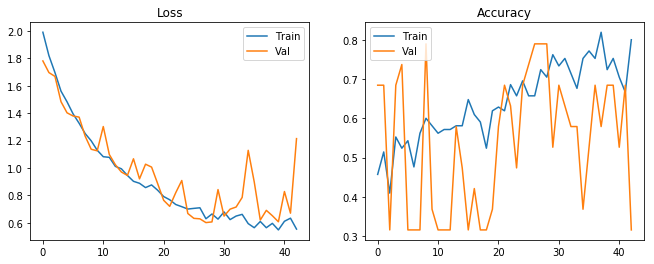

Trial 2
Epoch 1/200
27/27 [==============================] - 6s 204ms/step - loss: 1.9598 - acc: 0.5005 - val_loss: 1.8401 - val_acc: 0.8421

Epoch 00001: val_acc improved from -inf to 0.84211, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/MS_from_scratch/weights-augm-trial2-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 158ms/step - loss: 1.8075 - acc: 0.5458 - val_loss: 1.7551 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.84211
Epoch 3/200
27/27 [==============================] - 5s 178ms/step - loss: 1.6788 - acc: 0.5551 - val_loss: 1.6486 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.84211
Epoch 4/200
27/27 [==============================] - 5s 183ms/step - loss: 1.5499 - acc: 0.5829 - val_loss: 1.4865 - val_acc: 0.6842

Epoch 00004: val_acc did not improve from 0.84211
Epoch 5/200
27/27 [==============================] - 5s 182ms/step - loss: 1.4753 - acc: 0.4727 - val_loss: 1.4690 -


Epoch 00044: val_acc did not improve from 0.84211
Epoch 45/200
27/27 [==============================] - 5s 186ms/step - loss: 0.5491 - acc: 0.7776 - val_loss: 0.6627 - val_acc: 0.6316

Epoch 00045: val_acc did not improve from 0.84211
Epoch 46/200
27/27 [==============================] - 5s 176ms/step - loss: 0.4986 - acc: 0.8146 - val_loss: 0.9084 - val_acc: 0.5263

Epoch 00046: val_acc did not improve from 0.84211
Epoch 47/200
27/27 [==============================] - 5s 177ms/step - loss: 0.5321 - acc: 0.8146 - val_loss: 0.5938 - val_acc: 0.6316

Epoch 00047: val_acc did not improve from 0.84211
Epoch 48/200
27/27 [==============================] - 5s 178ms/step - loss: 0.4534 - acc: 0.8146 - val_loss: 0.6078 - val_acc: 0.8421

Epoch 00048: val_acc did not improve from 0.84211
Epoch 49/200
27/27 [==============================] - 5s 175ms/step - loss: 0.7045 - acc: 0.7034 - val_loss: 0.8476 - val_acc: 0.4211

Epoch 00049: val_acc did not improve from 0.84211
Epoch 50/200
27/27 [====

27/27 [==============================] - 5s 195ms/step - loss: 0.3095 - acc: 0.9444 - val_loss: 0.5379 - val_acc: 0.8421

Epoch 00088: val_acc did not improve from 0.84211
Epoch 89/200
27/27 [==============================] - 5s 184ms/step - loss: 0.2624 - acc: 0.9444 - val_loss: 0.5492 - val_acc: 0.8421

Epoch 00089: val_acc did not improve from 0.84211
Epoch 90/200
27/27 [==============================] - 5s 183ms/step - loss: 0.3089 - acc: 0.9083 - val_loss: 0.5466 - val_acc: 0.8421

Epoch 00090: val_acc did not improve from 0.84211
Epoch 91/200
27/27 [==============================] - 5s 180ms/step - loss: 0.2830 - acc: 0.9351 - val_loss: 0.5760 - val_acc: 0.8421

Epoch 00091: val_acc did not improve from 0.84211
Epoch 92/200
27/27 [==============================] - 5s 174ms/step - loss: 0.2678 - acc: 0.9537 - val_loss: 0.5673 - val_acc: 0.8947

Epoch 00092: val_acc improved from 0.84211 to 0.89474, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/MS_

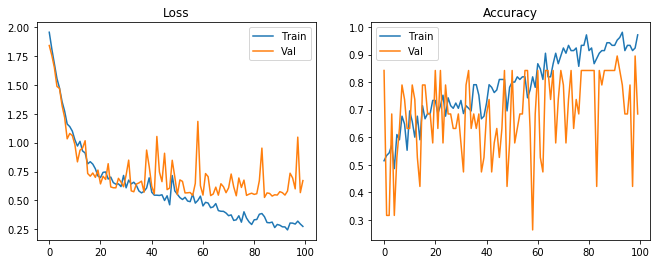

Trial 3
Epoch 1/200
27/27 [==============================] - 7s 253ms/step - loss: 1.9528 - acc: 0.4902 - val_loss: 1.9171 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/MS_from_scratch/weights-augm-trial3-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 157ms/step - loss: 1.7901 - acc: 0.5366 - val_loss: 1.7108 - val_acc: 0.8421

Epoch 00002: val_acc improved from 0.31579 to 0.84211, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/MS_from_scratch/weights-augm-trial3-improvement-BEST.hdf5
Epoch 3/200
27/27 [==============================] - 5s 170ms/step - loss: 1.6681 - acc: 0.5088 - val_loss: 1.7695 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.84211
Epoch 4/200
27/27 [==============================] - 5s 173ms/step - loss: 1.5696 - acc: 0.4634 - val_loss: 1.5032 - val_acc: 0.3684

Epoch 00004: val_acc di

27/27 [==============================] - 5s 180ms/step - loss: 0.5527 - acc: 0.7683 - val_loss: 0.5200 - val_acc: 0.8421

Epoch 00044: val_acc did not improve from 0.84211
Epoch 45/200
27/27 [==============================] - 5s 180ms/step - loss: 0.5928 - acc: 0.7127 - val_loss: 0.5347 - val_acc: 0.8421

Epoch 00045: val_acc did not improve from 0.84211
Epoch 46/200
27/27 [==============================] - 5s 183ms/step - loss: 0.5631 - acc: 0.8064 - val_loss: 0.5298 - val_acc: 0.8421

Epoch 00046: val_acc did not improve from 0.84211
Epoch 47/200
27/27 [==============================] - 5s 176ms/step - loss: 0.5276 - acc: 0.7961 - val_loss: 0.5149 - val_acc: 0.8421

Epoch 00047: val_acc did not improve from 0.84211
Epoch 48/200
27/27 [==============================] - 5s 176ms/step - loss: 0.5324 - acc: 0.7497 - val_loss: 0.5024 - val_acc: 0.8421

Epoch 00048: val_acc did not improve from 0.84211
Epoch 49/200
27/27 [==============================] - 5s 177ms/step - loss: 0.5142 - acc

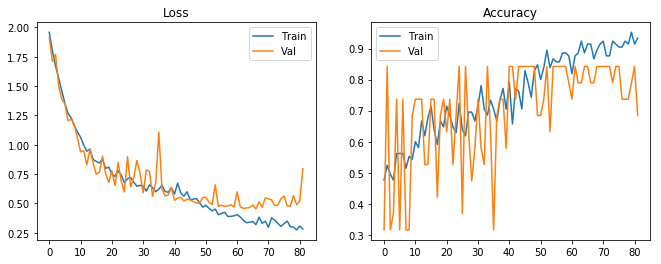

Trial 4
Epoch 1/200
27/27 [==============================] - 7s 259ms/step - loss: 1.9316 - acc: 0.5273 - val_loss: 1.8580 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/MS_from_scratch/weights-augm-trial4-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 155ms/step - loss: 1.7850 - acc: 0.5180 - val_loss: 1.7723 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.31579
Epoch 3/200
27/27 [==============================] - 5s 173ms/step - loss: 1.6509 - acc: 0.5098 - val_loss: 1.6377 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.31579
Epoch 4/200
27/27 [==============================] - 5s 176ms/step - loss: 1.5512 - acc: 0.5829 - val_loss: 1.7563 - val_acc: 0.3158

Epoch 00004: val_acc did not improve from 0.31579
Epoch 5/200
27/27 [==============================] - 5s 180ms/step - loss: 1.4690 - acc: 0.4995 - val_loss: 1.3951 -


Epoch 00040: val_acc did not improve from 0.84211
Epoch 41/200
27/27 [==============================] - 5s 176ms/step - loss: 0.6082 - acc: 0.6941 - val_loss: 0.6134 - val_acc: 0.6842

Epoch 00041: val_acc did not improve from 0.84211
Epoch 42/200
27/27 [==============================] - 5s 191ms/step - loss: 0.6043 - acc: 0.7405 - val_loss: 0.6401 - val_acc: 0.7368

Epoch 00042: val_acc did not improve from 0.84211
Epoch 43/200
27/27 [==============================] - 5s 182ms/step - loss: 0.5847 - acc: 0.7044 - val_loss: 0.5291 - val_acc: 0.7895

Epoch 00043: val_acc did not improve from 0.84211
Epoch 44/200
27/27 [==============================] - 5s 188ms/step - loss: 0.5839 - acc: 0.7127 - val_loss: 0.5363 - val_acc: 0.7368

Epoch 00044: val_acc did not improve from 0.84211
Epoch 45/200
27/27 [==============================] - 5s 187ms/step - loss: 0.5626 - acc: 0.7219 - val_loss: 0.5190 - val_acc: 0.8421

Epoch 00045: val_acc did not improve from 0.84211
Epoch 46/200
27/27 [====

27/27 [==============================] - 5s 175ms/step - loss: 0.3490 - acc: 0.9073 - val_loss: 0.4940 - val_acc: 0.8947

Epoch 00083: val_acc did not improve from 0.89474
Epoch 84/200
27/27 [==============================] - 5s 170ms/step - loss: 0.3245 - acc: 0.9444 - val_loss: 0.5262 - val_acc: 0.8947

Epoch 00084: val_acc did not improve from 0.89474
Epoch 85/200
27/27 [==============================] - 5s 180ms/step - loss: 0.3595 - acc: 0.8795 - val_loss: 0.5158 - val_acc: 0.8947

Epoch 00085: val_acc did not improve from 0.89474
Epoch 86/200
27/27 [==============================] - 5s 179ms/step - loss: 0.3464 - acc: 0.9259 - val_loss: 0.5144 - val_acc: 0.8947

Epoch 00086: val_acc did not improve from 0.89474
Epoch 87/200
27/27 [==============================] - 5s 181ms/step - loss: 0.3706 - acc: 0.8888 - val_loss: 0.7589 - val_acc: 0.5263

Epoch 00087: val_acc did not improve from 0.89474
Epoch 88/200
27/27 [==============================] - 5s 186ms/step - loss: 0.3462 - acc

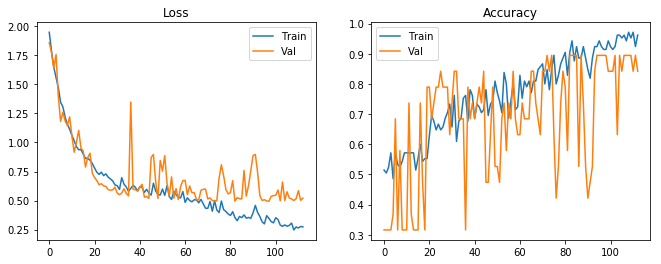

Trial 5
Epoch 1/200
27/27 [==============================] - 7s 258ms/step - loss: 1.9659 - acc: 0.5273 - val_loss: 1.7981 - val_acc: 0.6842

Epoch 00001: val_acc improved from -inf to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/MS_from_scratch/weights-augm-trial5-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 158ms/step - loss: 1.8264 - acc: 0.4624 - val_loss: 1.8930 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.68421
Epoch 3/200
27/27 [==============================] - 5s 177ms/step - loss: 1.7012 - acc: 0.4995 - val_loss: 1.7462 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.68421
Epoch 4/200
27/27 [==============================] - 5s 184ms/step - loss: 1.5864 - acc: 0.5644 - val_loss: 1.5339 - val_acc: 0.6316

Epoch 00004: val_acc did not improve from 0.68421
Epoch 5/200
27/27 [==============================] - 5s 184ms/step - loss: 1.5071 - acc: 0.5283 - val_loss: 1.6327 -

27/27 [==============================] - 5s 179ms/step - loss: 0.6558 - acc: 0.6849 - val_loss: 0.5374 - val_acc: 0.8421

Epoch 00041: val_acc improved from 0.78947 to 0.84211, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/MS_from_scratch/weights-augm-trial5-improvement-BEST.hdf5
Epoch 42/200
27/27 [==============================] - 5s 175ms/step - loss: 0.6123 - acc: 0.7044 - val_loss: 0.5614 - val_acc: 0.7368

Epoch 00042: val_acc did not improve from 0.84211
Epoch 43/200
27/27 [==============================] - 5s 174ms/step - loss: 0.6171 - acc: 0.7219 - val_loss: 0.7373 - val_acc: 0.5789

Epoch 00043: val_acc did not improve from 0.84211
Epoch 44/200
27/27 [==============================] - 5s 183ms/step - loss: 0.6448 - acc: 0.7322 - val_loss: 0.5366 - val_acc: 0.8421

Epoch 00044: val_acc did not improve from 0.84211
Epoch 45/200
27/27 [==============================] - 5s 175ms/step - loss: 0.6282 - acc: 0.7415 - val_loss: 0.5407 - val_acc: 0.8

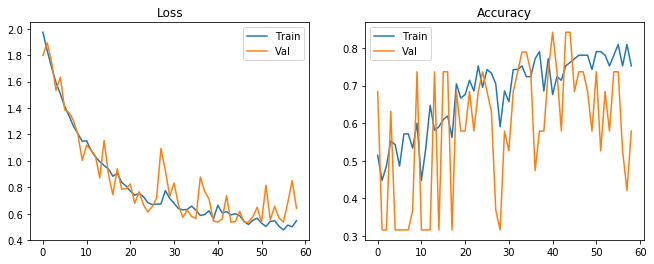

Trial 6
Epoch 1/200
27/27 [==============================] - 7s 264ms/step - loss: 1.9660 - acc: 0.4634 - val_loss: 1.7782 - val_acc: 0.6842

Epoch 00001: val_acc improved from -inf to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/MS_from_scratch/weights-augm-trial6-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 162ms/step - loss: 1.7567 - acc: 0.5283 - val_loss: 1.9220 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.68421
Epoch 3/200
27/27 [==============================] - 5s 175ms/step - loss: 1.6444 - acc: 0.5005 - val_loss: 1.5432 - val_acc: 0.6842

Epoch 00003: val_acc improved from 0.68421 to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/MS_from_scratch/weights-augm-trial6-improvement-BEST.hdf5
Epoch 4/200
27/27 [==============================] - 5s 184ms/step - loss: 1.4935 - acc: 0.4727 - val_loss: 1.3859 - val_acc: 0.7895

Epoch 00004: val_acc im

27/27 [==============================] - 5s 190ms/step - loss: 0.5558 - acc: 0.7415 - val_loss: 0.5332 - val_acc: 0.8421

Epoch 00042: val_acc did not improve from 0.84211
Epoch 43/200
27/27 [==============================] - 5s 187ms/step - loss: 0.5887 - acc: 0.6952 - val_loss: 0.5367 - val_acc: 0.8421

Epoch 00043: val_acc did not improve from 0.84211
Epoch 44/200
27/27 [==============================] - 5s 175ms/step - loss: 0.5995 - acc: 0.7219 - val_loss: 0.5673 - val_acc: 0.7368

Epoch 00044: val_acc did not improve from 0.84211
Epoch 45/200
27/27 [==============================] - 5s 180ms/step - loss: 0.5710 - acc: 0.7137 - val_loss: 0.6241 - val_acc: 0.6316

Epoch 00045: val_acc did not improve from 0.84211
Epoch 46/200
27/27 [==============================] - 5s 176ms/step - loss: 0.5764 - acc: 0.7776 - val_loss: 0.5836 - val_acc: 0.6842

Epoch 00046: val_acc did not improve from 0.84211
Epoch 47/200
27/27 [==============================] - 5s 178ms/step - loss: 0.5795 - acc

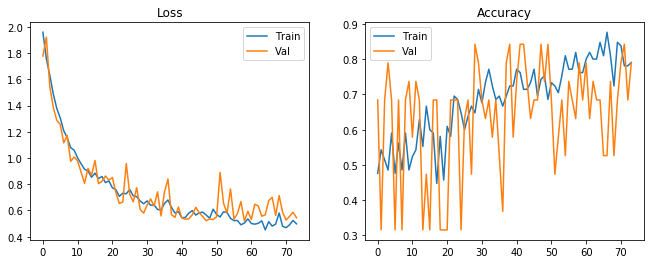

Trial 7
Epoch 1/200
27/27 [==============================] - 8s 283ms/step - loss: 1.9516 - acc: 0.5551 - val_loss: 1.9116 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/MS_from_scratch/weights-augm-trial7-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 154ms/step - loss: 1.8186 - acc: 0.5458 - val_loss: 1.7896 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.31579
Epoch 3/200
27/27 [==============================] - 5s 182ms/step - loss: 1.6686 - acc: 0.5458 - val_loss: 1.6773 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.31579
Epoch 4/200
27/27 [==============================] - 5s 178ms/step - loss: 1.5391 - acc: 0.5747 - val_loss: 1.4161 - val_acc: 0.6842

Epoch 00004: val_acc improved from 0.31579 to 0.68421, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/MS_from_scratch/weights-augm-tr

27/27 [==============================] - 5s 175ms/step - loss: 0.5980 - acc: 0.7405 - val_loss: 0.6204 - val_acc: 0.5789

Epoch 00041: val_acc did not improve from 0.84211
Epoch 42/200
27/27 [==============================] - 5s 184ms/step - loss: 0.5777 - acc: 0.7497 - val_loss: 0.6114 - val_acc: 0.5789

Epoch 00042: val_acc did not improve from 0.84211
Epoch 43/200
27/27 [==============================] - 5s 187ms/step - loss: 0.5622 - acc: 0.7322 - val_loss: 0.5416 - val_acc: 0.7895

Epoch 00043: val_acc did not improve from 0.84211
Epoch 44/200
27/27 [==============================] - 5s 184ms/step - loss: 0.5977 - acc: 0.7044 - val_loss: 0.5667 - val_acc: 0.6842

Epoch 00044: val_acc did not improve from 0.84211
Epoch 45/200
27/27 [==============================] - 5s 178ms/step - loss: 0.5935 - acc: 0.6673 - val_loss: 0.5311 - val_acc: 0.8421

Epoch 00045: val_acc did not improve from 0.84211
Epoch 46/200
27/27 [==============================] - 5s 174ms/step - loss: 0.6429 - acc

27/27 [==============================] - 5s 172ms/step - loss: 0.2909 - acc: 0.9351 - val_loss: 0.5195 - val_acc: 0.8421

Epoch 00085: val_acc did not improve from 0.84211
Epoch 00085: early stopping


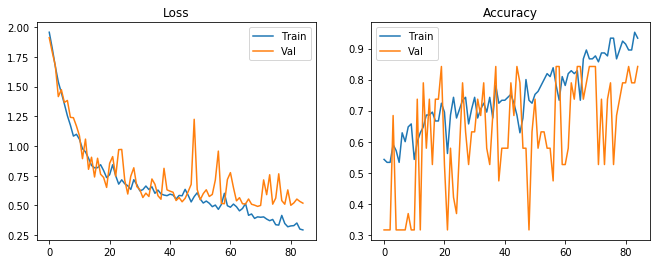

Trial 8
Epoch 1/200
27/27 [==============================] - 7s 265ms/step - loss: 1.9423 - acc: 0.4634 - val_loss: 1.9025 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/MS_from_scratch/weights-augm-trial8-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 153ms/step - loss: 1.7789 - acc: 0.4912 - val_loss: 1.8500 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.31579
Epoch 3/200
27/27 [==============================] - 5s 173ms/step - loss: 1.6625 - acc: 0.4542 - val_loss: 1.6124 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.31579
Epoch 4/200
27/27 [==============================] - 4s 162ms/step - loss: 1.5237 - acc: 0.5551 - val_loss: 1.4605 - val_acc: 0.6316

Epoch 00004: val_acc improved from 0.31579 to 0.63158, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/MS_from_scratch/weights-augm-tr


Epoch 00040: val_acc did not improve from 0.84211
Epoch 41/200
27/27 [==============================] - 5s 179ms/step - loss: 0.6188 - acc: 0.7219 - val_loss: 0.5302 - val_acc: 0.8421

Epoch 00041: val_acc did not improve from 0.84211
Epoch 42/200
27/27 [==============================] - 5s 178ms/step - loss: 0.6028 - acc: 0.6952 - val_loss: 0.6111 - val_acc: 0.6842

Epoch 00042: val_acc did not improve from 0.84211
Epoch 43/200
27/27 [==============================] - 5s 186ms/step - loss: 0.5337 - acc: 0.7776 - val_loss: 1.2370 - val_acc: 0.3158

Epoch 00043: val_acc did not improve from 0.84211
Epoch 44/200
27/27 [==============================] - 5s 182ms/step - loss: 0.6280 - acc: 0.7312 - val_loss: 0.6452 - val_acc: 0.6316

Epoch 00044: val_acc did not improve from 0.84211
Epoch 45/200
27/27 [==============================] - 5s 184ms/step - loss: 0.5483 - acc: 0.7405 - val_loss: 0.7447 - val_acc: 0.5789

Epoch 00045: val_acc did not improve from 0.84211
Epoch 46/200
27/27 [====

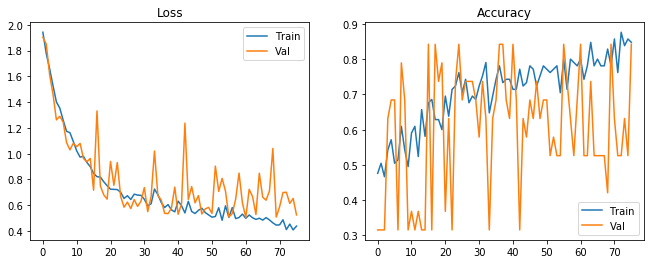

Trial 9
Epoch 1/200
27/27 [==============================] - 8s 306ms/step - loss: 1.9502 - acc: 0.4912 - val_loss: 1.8398 - val_acc: 0.3158

Epoch 00001: val_acc improved from -inf to 0.31579, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/MS_from_scratch/weights-augm-trial9-improvement-BEST.hdf5
Epoch 2/200
27/27 [==============================] - 4s 158ms/step - loss: 1.7781 - acc: 0.4542 - val_loss: 1.6819 - val_acc: 0.3158

Epoch 00002: val_acc did not improve from 0.31579
Epoch 3/200
27/27 [==============================] - 5s 183ms/step - loss: 1.6093 - acc: 0.5736 - val_loss: 1.7298 - val_acc: 0.3158

Epoch 00003: val_acc did not improve from 0.31579
Epoch 4/200
27/27 [==============================] - 5s 188ms/step - loss: 1.5147 - acc: 0.5458 - val_loss: 1.6553 - val_acc: 0.3158

Epoch 00004: val_acc did not improve from 0.31579
Epoch 5/200
27/27 [==============================] - 5s 178ms/step - loss: 1.4192 - acc: 0.5098 - val_loss: 1.3915 -

27/27 [==============================] - 5s 181ms/step - loss: 0.6083 - acc: 0.7219 - val_loss: 0.8527 - val_acc: 0.4737

Epoch 00041: val_acc did not improve from 0.84211
Epoch 42/200
27/27 [==============================] - 5s 179ms/step - loss: 0.6024 - acc: 0.6859 - val_loss: 0.6237 - val_acc: 0.5789

Epoch 00042: val_acc did not improve from 0.84211
Epoch 43/200
27/27 [==============================] - 5s 181ms/step - loss: 0.5686 - acc: 0.7127 - val_loss: 0.6505 - val_acc: 0.5789

Epoch 00043: val_acc did not improve from 0.84211
Epoch 44/200
27/27 [==============================] - 5s 177ms/step - loss: 0.5866 - acc: 0.7137 - val_loss: 0.5323 - val_acc: 0.7895

Epoch 00044: val_acc did not improve from 0.84211
Epoch 45/200
27/27 [==============================] - 5s 192ms/step - loss: 0.5566 - acc: 0.7405 - val_loss: 0.5836 - val_acc: 0.5789

Epoch 00045: val_acc did not improve from 0.84211
Epoch 46/200
27/27 [==============================] - 5s 186ms/step - loss: 0.6025 - acc

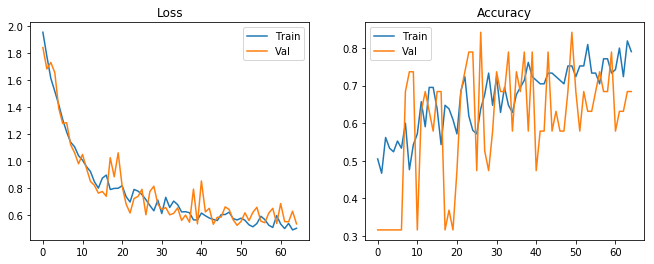

Training Time: 1.0h:4.0m:54.429643630981445s
Validation final accuracies: 
 [0.6842105278843328, 0.3157894736842105, 0.6842105294528761, 0.6842105294528761, 0.8421052631578947, 0.578947369989596, 0.7894736873476129, 0.8421052631578947, 0.8421052662949813, 0.6842105278843328]
Validation final accuracies mean: 0.6947368438306607
Validation best accuracies: 
 [0.8421052662949813, 0.7894736842105263, 0.8947368421052632, 0.8421052631578947, 0.8947368421052632, 0.8421052631578947, 0.8421052631578947, 0.8421052631578947, 0.8421052662949813, 0.8421052631578947]
Validation best accuracies mean: 0.8473684216800489
Validation balanced accuracies: 
 [0.7243589743589745, 0.5, 0.7243589743589745, 0.7243589743589745, 0.7948717948717949, 0.6474358974358975, 0.7115384615384616, 0.75, 0.7948717948717949, 0.6346153846153846]
Validation balanced accuracies mean: 0.7006410256410257
Validation final sensitivities: 
 [0.8333333333333334, 1.0, 0.8333333333333334, 0.8333333333333334, 0.6666666666666666, 0.8333

In [19]:
# training args
lr = 0.0005
lr_decay = 0.002
transforms = [intensity, sagittal_flip, translate]

num_trials = 10
store_models = True

accuracies = []
balanced_accuracies = []
sensitivities = []
specificities = []
max_acc = []

for i in range(num_trials):
    print("Trial %i" %i)
    
    # init model
    model = SixtyFourNet(drop_rate=0.3, weight_dcay=0.01, input_shape=X_train.shape)
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(optimizer=opti, loss='binary_crossentropy', metrics=['accuracy'])
    
    # callbacks
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')
    if store_models:
        result_path = os.path.join(result_dir, "weights-augm-trial%i-improvement-BEST.hdf5" %i)
        model_checkpoint = ModelCheckpoint(result_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
        callbacks = [earlystop, model_checkpoint]
    else:
        callbacks = [earlystop]
        
    train_loader = CISDataset(X_train, y_train, transform=transforms, batch_size=b, shuffle=True)
    val_loader = CISDataset(X_val, y_val, transform=[intensity], batch_size=4, shuffle=False)
    
    # Start training
    history = model.fit_generator(train_loader,
                        epochs=num_epochs,
                        validation_data=val_loader,
                        callbacks=callbacks)
    # Plot training curves
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Val"])
    plt.title("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.legend(["Train", "Val"])
    plt.title("Accuracy")
    plt.show()
    # Evaluation
    y_pred = model.predict_generator(val_loader)
    #y_true = [item for sublist in [val_loader[batch_idx][1] for batch_idx in range(len(val_loader))] for item in sublist]
    bal_acc = balanced_accuracy(y_val, y_pred>0.5)
    sens = sensitivity(y_val, y_pred>0.5)
    spec = specificity(y_val, y_pred>0.5)
    # Store results
    accuracies.append(history.history["val_acc"][-1])
    balanced_accuracies.append(bal_acc)
    max_acc.append(np.max(history.history["val_acc"]))
    sensitivities.append(sens)
    specificities.append(spec)

training_time = time.time() - start_time
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))
# Print results
print("Validation final accuracies: \n {}".format(accuracies))
print("Validation final accuracies mean: {}".format(np.mean(accuracies)))
print("Validation best accuracies: \n {}".format(max_acc))
print("Validation best accuracies mean: {}".format(np.mean(max_acc)))
print("Validation balanced accuracies: \n {}".format(balanced_accuracies))
print("Validation balanced accuracies mean: {}".format(np.mean(balanced_accuracies)))
print("Validation final sensitivities: \n {}".format(sensitivities))
print("Validation final sensitivities' mean: {}".format(np.mean(sensitivities)))
print("Validation final specificities: \n {}".format(specificities))
print("Validation final specificities' mean: {}".format(np.mean(specificities)))

In [20]:
training_time = time.time() - start_time

# Evaluation

In [21]:
weights = ["weights-augm-trial%i-improvement-BEST.hdf5"%i for i in range(num_trials)]

In [22]:
# load holdout set
test_loader = CISDataset(X_holdout, y_holdout, transform=[intensity], batch_size=1, shuffle=False)

Fold 0


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 73.91 %
Balanced accuracy 72.31 %
Sensitivity 84.62 %
Specificity 60.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 86.15
Fold 1


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 69.57 %
Balanced accuracy 71.92 %
Sensitivity 53.85 %
Specificity 90.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 85.38
Fold 2


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 78.26 %
Balanced accuracy 76.15 %
Sensitivity 92.31 %
Specificity 60.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 92.31
Fold 3


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 47.83 %
Balanced accuracy 51.54 %
Sensitivity 23.08 %
Specificity 80.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 77.69
Fold 4


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 73.91 %
Balanced accuracy 72.31 %
Sensitivity 84.62 %
Specificity 60.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 85.38
Fold 5


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 73.91 %
Balanced accuracy 75.77 %
Sensitivity 61.54 %
Specificity 90.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 84.62
Fold 6


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 69.57 %
Balanced accuracy 70.77 %
Sensitivity 61.54 %
Specificity 80.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 84.62
Fold 7


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 73.91 %
Balanced accuracy 74.62 %
Sensitivity 69.23 %
Specificity 80.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 88.46
Fold 8


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 78.26 %
Balanced accuracy 76.15 %
Sensitivity 92.31 %
Specificity 60.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 84.62
Fold 9


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 69.57 %
Balanced accuracy 70.77 %
Sensitivity 61.54 %
Specificity 80.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 85.38
######## Final results ########
Accuracy mean 70.87 %
Balanced accuracy mean 71.23 %
Sensitivity mean 68.46 %
Specificity mean 74.00 %
Mean ROC AUC score 85.46


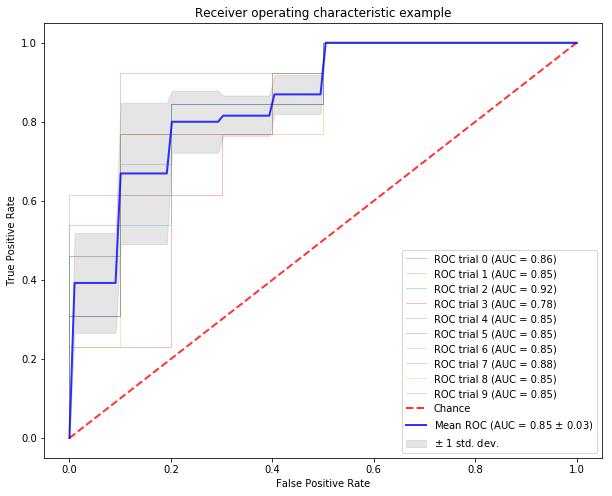

In [23]:
accuracies = []
balanced_accuracies = []
sensitivities = []
specificities = []
auc_scores = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))

for fold, weight in enumerate(weights):
    print("Fold {}".format(fold))
    model = SixtyFourNet(drop_rate=0.3, weight_dcay=0.01, input_shape=X_train.shape)
    model_dir = os.path.join(result_dir, weight)
    model.load_weights(model_dir)
    
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(optimizer=opti,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    # Evaluate
    res = model.evaluate_generator(test_loader)
    y_pred = model.predict_generator(test_loader)
    bal_acc = balanced_accuracy(y_holdout, y_pred>0.5)
    sens = sensitivity(y_holdout, y_pred>0.5)
    spec = specificity(y_holdout, y_pred>0.5)
    roc_auc = roc_auc_score(y_holdout, y_pred)
    fpr, tpr, thresholds = roc_curve(y_holdout, y_pred)   
    # Store results
    accuracies.append(res[1])
    balanced_accuracies.append(bal_acc)
    sensitivities.append(sens)
    specificities.append(spec)
    auc_scores.append(roc_auc)
    # interpolate with diagonal to get comparable results
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0 # correct lowest value after interpolation
    # Print results
    print("Model accuracy {:.2f} %".format(res[1]*100))
    print("Balanced accuracy {:.2f} %".format(bal_acc*100))
    print("Sensitivity {:.2f} %".format(sens*100))
    print("Specificity {:.2f} %".format(spec*100))
    print("Area Under the Receiver Operating Curve (ROC AUC score) {:.2f}".format(roc_auc*100))
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC trial %d (AUC = %0.2f)' % (fold, roc_auc))
    
print("######## Final results ########")
print("Accuracy mean {:.2f} %".format(np.mean(accuracies)*100))
print("Balanced accuracy mean {:.2f} %".format(np.mean(balanced_accuracies)*100))
print("Sensitivity mean {:.2f} %".format(np.mean(sensitivities)*100))
print("Specificity mean {:.2f} %".format(np.mean(specificities)*100))
print("Mean ROC AUC score {:.2f}".format(np.mean(auc_scores)*100))

# Plot ROC Curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0 # correct max value after interpolation and mean
mean_auc = auc(mean_fpr, mean_tpr)
#assert(mean_auc == np.mean(auc_scores))

std_auc = np.std(auc_scores)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [24]:
total_time = time.time() - start_time

In [25]:
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))
print("Total time elapsed: {}h:{}m:{}s".format(
            total_time//3600, (total_time//60)%60, total_time%60))

Training Time: 1.0h:4.0m:54.43931269645691s
Total time elapsed: 1.0h:6.0m:13.00552773475647s


In [26]:
quit()